In [106]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from build_vocab import Vocabulary
from PIL import Image
import pandas as pd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        print(self.linear)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            #print(hiddens.shape)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            #print(predicted.shape)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [52]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [239]:
# Load vocabulary wrapper
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    
vocab.idx2word[1]
vocab.word2idx["<end>"]

2

In [54]:
encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(256, 512, len(vocab), 1)
encoder = encoder.to(device)
decoder = decoder.to(device)

Linear(in_features=2048, out_features=256, bias=True)


In [55]:
# Load the trained model parameters
encoder.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
decoder.load_state_dict(torch.load('models/decoder-5-3000.pkl'))
decoder

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)

In [56]:
# Prepare an image
image_path = "png/example.png"
image = load_image(image_path, transform)
image_tensor = image.to(device)

_image = mpimg.imread(image_path)
#plt.imshow(_image)

In [250]:
def sample_beam(encoder, decoder,image_tensor,word_map,k=5):
    """Generate captions of given image using beam search"""
    vocab_size = len(word_map)
    encoder_out = encoder(image_tensor)
    encoder_out = encoder_out.unsqueeze(0)
    encoder_out = encoder_out.expand(k,encoder_out.size(1),encoder_out.size(2))
    
    print(encoder_out.size())
    
    k_prev_words = torch.LongTensor([[word_map.word2idx["<start>"]]]*k).to(device)
    seqs = k_prev_words
    top_k_scores = torch.zeros(k,1).to(device)
    top_k_scores=top_k_scores
    print(top_k_scores.size())
    print(seqs)
    
    complete_seqs = list()
    complete_seqs_scores = list()
    
    step = 1
    print("----- Begining Decoding ------")
    while True:
        print("***********STEP {}***********".format(step))
        h,c = decoder.lstm(encoder_out,None)
        output = decoder.linear(h.squeeze(1))
        scores = F.log_softmax(output,dim=1)
        scores = top_k_scores.expand_as(scores)+scores
        
        if step==1:
            top_k_scores,top_k_words = scores[0].topk(k,0,True,True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
        
        prev_word_inds = top_k_words/vocab_size
        next_word_inds = top_k_words % 9956
        
        seqs = torch.cat([seqs[prev_word_inds],next_word_inds.unsqueeze(1)],dim=1)
        
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map.word2idx['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
        
        if len(complete_inds)>0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        
        k -=len(complete_inds)
        
        if k==0:
            break
        else:
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = (h,h)
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
        
        if step == 30:
            
            break
        step += 1
        #print(scores[0].topk(k, 0, True, True)[0].unsqueeze(1).size())
        #print(scores.size())
        #print(top_k_scores)
        print(vocab_size)
        print("topk:",top_k_words)
        print("Prev",prev_word_inds)
        print("Next",next_word_inds)
        #print(seqs)
        
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    return seq
        
        
    
    
    
    
    
print(vocab.idx2word[1])    

<start>


In [251]:
19913 % 699

341

In [248]:
bm_encoder = encoder
bm_decoder = decoder

sample_beam(decoder=bm_decoder,encoder=bm_encoder,image_tensor=image_tensor,word_map=vocab)

torch.Size([5, 1, 256])
torch.Size([5, 1])
tensor([[ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1]], device='cuda:0')
----- Begining Decoding ------
***********STEP 1***********
9956
tensor([    1,   699,  3151,  7423,  5029], device='cuda:0')
***********STEP 2***********
9956
tensor([     1,   9957,    699,  19913,   3151], device='cuda:0')
***********STEP 3***********
9956
tensor([     1,  19913,    699,   9957,   3151], device='cuda:0')
***********STEP 4***********
9956
tensor([     1,  19913,    699,  29869,   9957], device='cuda:0')
***********STEP 5***********
9956
tensor([     1,  19913,    699,  29869,   9957], device='cuda:0')
***********STEP 6***********
9956
tensor([     1,  19913,    699,  29869,   9957], device='cuda:0')
***********STEP 7***********
9956
tensor([     1,  19913,    699,  29869,   9957], device='cuda:0')
***********STEP 8***********
9956
tensor([     1,  19913,    699,  29869,   9957], device='cuda:0')
***********STEP 9***********
9956
tensor([ 

ValueError: max() arg is an empty sequence

In [208]:
# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

In [ ]:
sample_beam(decoder=bm_decoder,encoder=bm_encoder,image_tensor=image_tensor,word_map=vocab)

In [11]:
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

<start> a group of giraffes standing next to each other . <end>


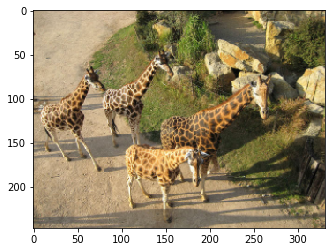

In [12]:
# Print out the image and the generated caption
print (sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image))

/home/pramod/anaconda3/envs/py35th/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


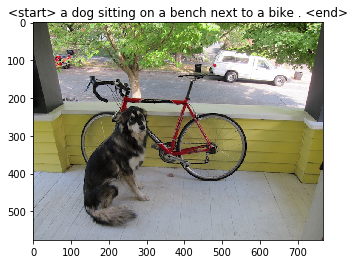

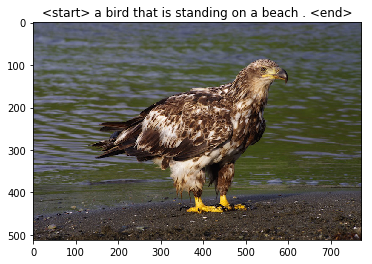

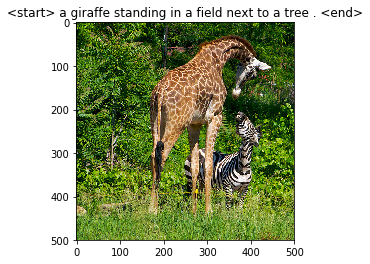

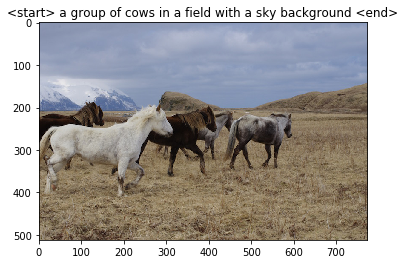

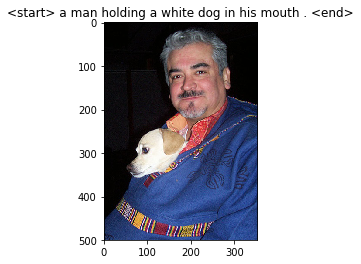

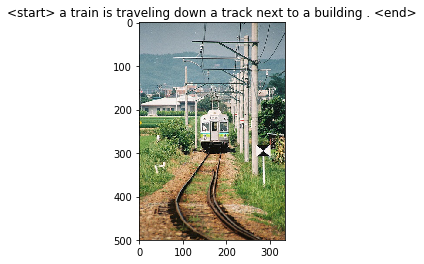

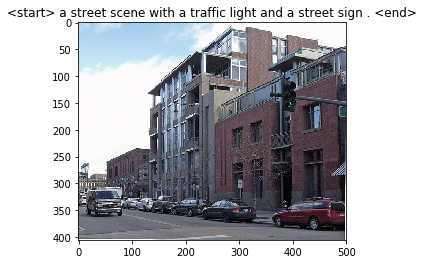

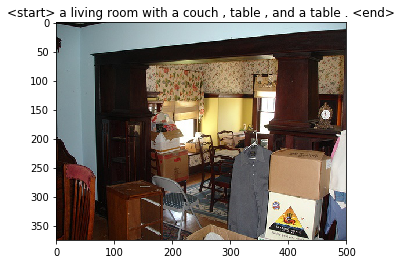

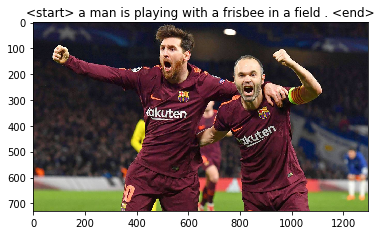

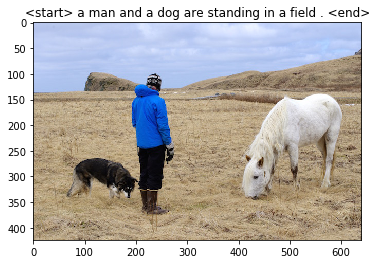

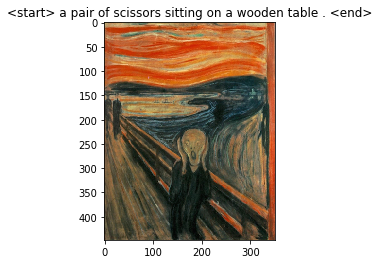

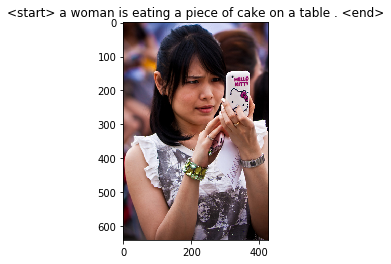

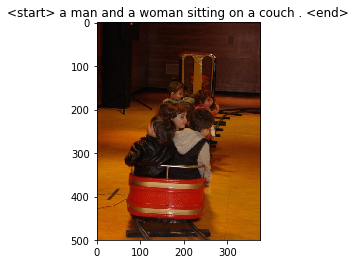

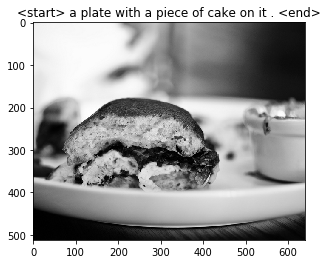

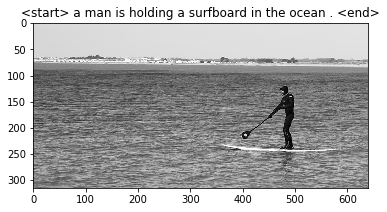

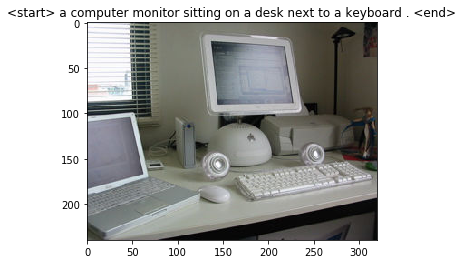

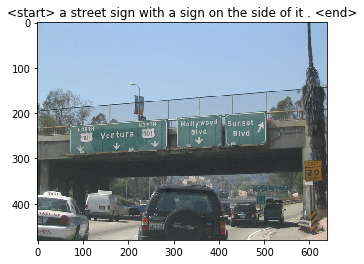

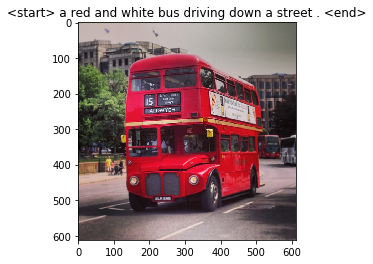

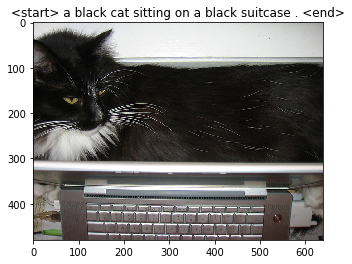

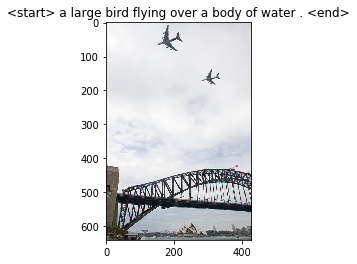

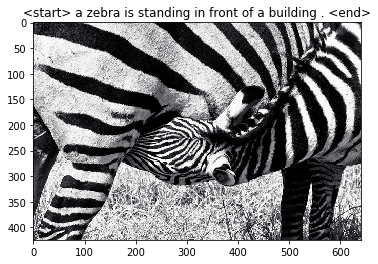

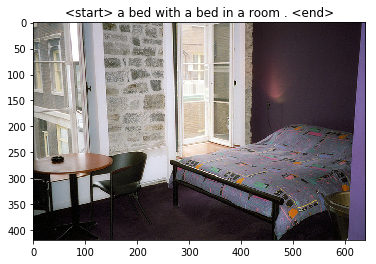

In [18]:
show_tell_df = pd.DataFrame()

images = "./imgs/"
for img in os.listdir(images):
        if os.path.splitext(img)[1] == '.png' or os.path.splitext(img)[1] =='.jpeg' or os.path.splitext(img)[1] =='.jpg':
            #print(img.split()[0])
            image = load_image("./imgs/"+img, transform)
            image_tensor = image.to(device)
            feature = encoder(image_tensor)
            sampled_ids = decoder.sample(feature)
            sampled_ids = sampled_ids[0].cpu().numpy()
            # Convert word_ids to words
            sampled_caption = []
            for word_id in sampled_ids:
                word = vocab.idx2word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            #_image = mpimg.imread("./imgs/"+img)
            #plt.imshow(_image)
            #print(sentence)
            show_tell_df = show_tell_df.append(
                pd.DataFrame({'img':img,'sat':sentence},index=[0]),ignore_index=True)
            _image = mpimg.imread("./imgs/"+img)
            plt.figure()
            plt.title(sentence)
            plt.imshow(_image)

In [19]:
show_tell_df

,img,sat
0,dog.jpg,<start> a dog sitting on a bench next to a bik...
1,eagle.jpg,<start> a bird that is standing on a beach . <...
2,giraffe.jpg,<start> a giraffe standing in a field next to ...
3,herd_of_horses.jpg,<start> a group of cows in a field with a sky ...
4,img1.jpg,<start> a man holding a white dog in his mouth...
5,img2.jpg,<start> a train is traveling down a track next...
6,img3.jpg,<start> a street scene with a traffic light an...
7,img4.jpg,"<start> a living room with a couch , table , a..."
8,messi.jpg,<start> a man is playing with a frisbee in a f...
9,person.jpg,<start> a man and a dog are standing in a fiel...


In [20]:
results = pd.read_csv('results.csv',names=["img", "yolo"])
results

,img,yolo
0,000000001584.jpg,"['person', 'person', 'person', 'person', 'bus'..."
1,giraffe.jpg,"['zebra', 'giraffe', 'giraffe']"
2,img4.jpg,"['chair', 'chair', 'chair', 'clock']"
3,000000001296.jpg,"['person', 'person', 'cell phone']"
4,000000001503.jpg,"['tvmonitor', 'laptop', 'mouse', 'keyboard']"
5,000000001490.jpg,['person']
6,000000001353.jpg,"['person', 'person', 'person', 'person', 'pers..."
7,scream.jpg,[]
8,000000001818.jpg,['zebra']
9,000000001425.jpg,"['bowl', 'sandwich']"


In [21]:
pd.merge(results,show_tell_df,on="img").to_csv("yolo_sat.csv")